### Import libraries

In [1]:
%%capture
#!pip install scanpy
#!pip install KDEpy
#!pip install leidenalg

In [2]:
%%capture
# Remember to restart the kernel once installed
#!pip install -e ../../../tools/nomad/

In [1]:
import os
import sys

import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import scipy.sparse as sps
from scipy.stats import spearmanr, kendalltau, pearsonr, ranksums

# to be able to import from tools dir
module_path = os.path.abspath(os.path.join("../"))
if module_path not in sys.path:
    sys.path.append(module_path)

import tools.util as ut
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co
import tools.NB_est as nb
import tools.ClusterDE as cd

import fi_nomad as nmd
from fi_nomad.types import kernelInputTypes
from fi_nomad.types import KernelStrategy
from fi_nomad.types import InitializationStrategy

import warnings

warnings.filterwarnings("ignore")

import importlib
import logging

In [2]:
# logging has to manually turned on to see nomad output
logging.basicConfig(level=logging.INFO)

### Read data

In [3]:
data_path = "../data/S3"
figure_path = f"{data_path}/figures/normalized_counts_r3"
layer = "normalized_counts"

In [4]:
data = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed_and_pca.h5ad")
data

AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt_PCA'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std'
    uns: 'BacSC_params_PCA', 'PCA', 'leiden', 'leiden_opt_PCA_colors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'normalized_counts', 'vst_counts'
    obsp: 'PCA_connectivities', 'PCA_distances'

### Countsplit

In [5]:
data_train, data_test = cs.countsplit_adata(
    data,
    data_dist="NB",
    beta_key="nb_overdisp_cutoff",
    layer=layer,
    min_genes=1,
    max_counts=1e9,
    seed=1234,
)

In [6]:
k_opt = 3
beta_opt = 0.7

In [7]:
data.uns["BacSC_params_NMD"] = {"k_opt": k_opt, "beta_opt": beta_opt}

## Fit NMD

In [8]:
n, p = data.X.shape

In [9]:
X_nmd = ut.convert_to_dense(data, layer=layer)
X_nmd = X_nmd.astype(float)
W0, H0 = cs.nuclear_norm_init(X_nmd, n, p, k_opt)
Theta0 = W0 @ H0

In [10]:
init_strat = InitializationStrategy.KNOWN_MATRIX
kernel_strat = KernelStrategy.MOMENTUM_3_BLOCK_MODEL_FREE

In [11]:
kernel_params = kernelInputTypes.Momentum3BlockAdditionalParameters(
    momentum_beta=beta_opt,
    candidate_factor_W0=W0,
    candidate_factor_H0=H0,
)
nmd_result = nmd.decompose(
    X_nmd,
    k_opt,
    kernel_strategy=kernel_strat,
    initialization=init_strat,
    kernel_params=kernel_params,
    manual_max_iterations=200,
    verbose=True,
    tolerance=None,
)

INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None
INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 0.00013055698946118355 loop took 45.043793877994176 overall (0.22521896938997088/ea)


In [12]:
data.obsm["X_nmd"] = nmd_result.factors[0]
data.varm["nmd_components"] = nmd_result.factors[1].T
data.layers["Theta_nmd"] = nmd_result.factors[0] @ nmd_result.factors[1]

## Investigate NMD embeddings, "components" and reconstruction

#### Reconstruction

Plot reconstruction of the data before and after fitting NMD.

In [15]:
df_reconstruction_nuclearinit_nmd = pd.DataFrame.from_dict(
    {
        layer: ut.convert_to_dense_counts(data, layer=layer).flatten(),
        "nuclear_init": np.maximum(0, W0 @ H0).flatten(),
        "3B-NMD": np.maximum(
            0, data.obsm["X_nmd"] @ data.varm["nmd_components"].T
        ).flatten(),
    }
)

max_val = max(
    np.max(df_reconstruction_nuclearinit_nmd[layer]),
    np.max(df_reconstruction_nuclearinit_nmd["nuclear_init"]),
    np.max(df_reconstruction_nuclearinit_nmd["3B-NMD"]),
)

corr_orig_nuclear = np.corrcoef(
    df_reconstruction_nuclearinit_nmd[layer],
    df_reconstruction_nuclearinit_nmd["nuclear_init"],
)[0][1]
corr_orig_3bnmd = np.corrcoef(
    df_reconstruction_nuclearinit_nmd[layer],
    df_reconstruction_nuclearinit_nmd["3B-NMD"],
)[0][1]

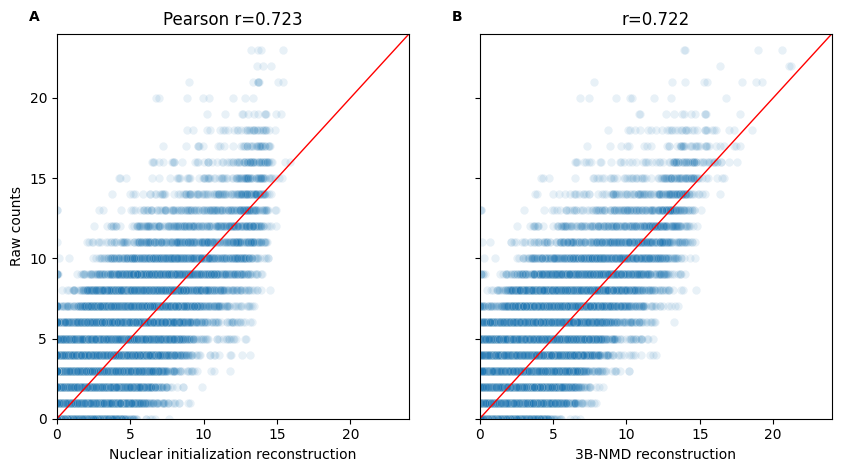

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

sns.scatterplot(
    data=df_reconstruction_nuclearinit_nmd, y=layer, x="nuclear_init", alpha=0.1, ax=ax1
)
ax1.set_title(f"Pearson r={corr_orig_nuclear:.3f}")
ax1.axline(xy1=(0, 0), slope=1, linewidth=1, color="r")
ax1.set_ylim((0, max_val + 1))
ax1.set_xlim((0, max_val + 1))
ax1.set_ylabel("Raw counts")
ax1.set_xlabel("Nuclear initialization reconstruction")
trans = mtransforms.ScaledTranslation(-20 / 72, 7 / 72, fig.dpi_scale_trans)
ax1.text(
    0.0,
    1.0,
    "A",
    transform=ax1.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)

sns.scatterplot(
    data=df_reconstruction_nuclearinit_nmd, y=layer, x="3B-NMD", alpha=0.1, ax=ax2
)
ax2.set_title(f"r={corr_orig_3bnmd:.3f}")
ax2.axline(xy1=(0, 0), slope=1, linewidth=1, color="r")
# ax2.set_ylim((0, max_val))
# ax2.set_xlim((0, max_val))
ax2.set_ylabel(None)
ax2.set_xlabel("3B-NMD reconstruction")
trans = mtransforms.ScaledTranslation(-20 / 72, 7 / 72, fig.dpi_scale_trans)
ax2.text(
    0.0,
    1.0,
    "B",
    transform=ax2.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)

# plt.savefig(f"{figure_path}/reconstruction_nuclear_init_vs_3bnmd.svg", format="svg")
plt.savefig(
    f"{figure_path}/reconstruction_nuclear_init_vs_3bnmd.png", format="png", dpi=300
)
plt.show()

#### NMD embeddings: before and after fitting

Comparison of NMD embeddings before (results of nuclear initialization) and after fitting NMD

In [17]:
W0_length = len(W0[:, 0:1].flatten())
dict_histogram_W0nuclear_vs_W_nmd = {
    "dim_1": np.concatenate((W0[:, 0:1], data.obsm["X_nmd"][:, 0:1])).flatten(),
    "dim_2": np.concatenate((W0[:, 1:2], data.obsm["X_nmd"][:, 1:2])).flatten(),
    "dim_3": np.concatenate((W0[:, 2:3], data.obsm["X_nmd"][:, 2:3])).flatten(),
    "W0_W_nmd": ["W0 (nuclear init.)"] * W0_length + ["W (3B-NMD)"] * W0_length,
}
df_histogram_W0nuclear_vs_W_nmd_r1 = pd.DataFrame.from_dict(
    dict_histogram_W0nuclear_vs_W_nmd
)

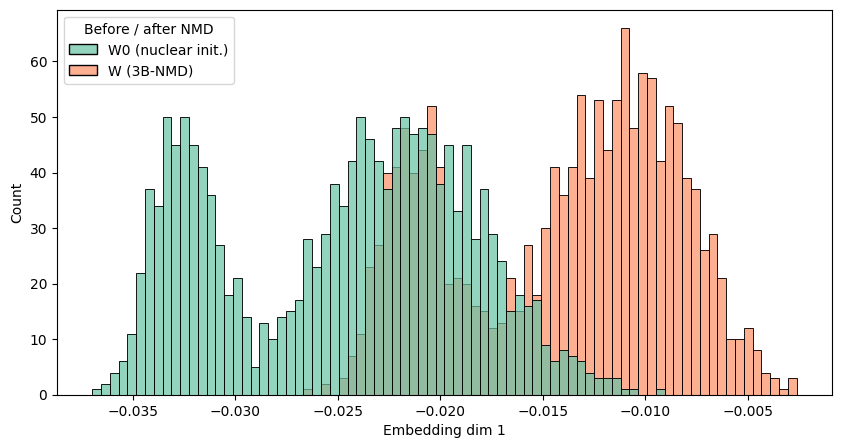

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
histogram_W0_dim1_nuclear_vs_W_nmd_r1 = sns.histplot(
    data=df_histogram_W0nuclear_vs_W_nmd_r1,
    x="dim_1",
    hue="W0_W_nmd",
    bins=80,
    alpha=0.7,
    palette="Set2",
)
histogram_W0_dim1_nuclear_vs_W_nmd_r1.legend_.set_title("Before / after NMD")
ax.set_xlabel("Embedding dim 1")

plt.savefig(f"{figure_path}/histogram_W0_dim1_nuclear_vs_W_nmd.svg", format="svg")
plt.show()

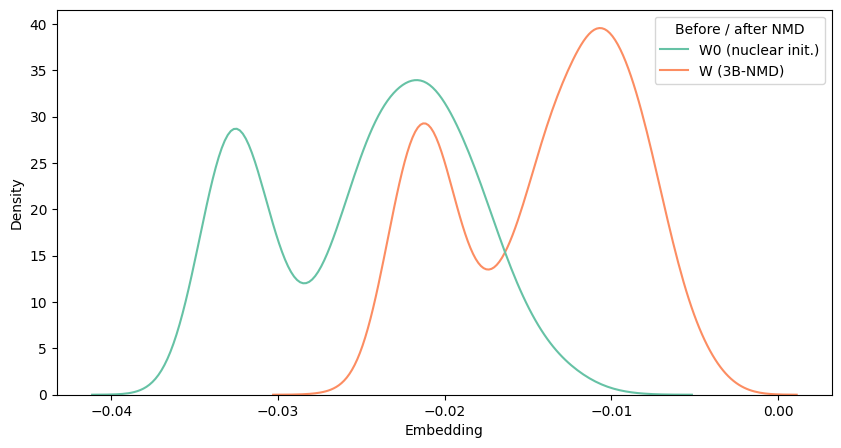

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
kdeplot_W0_dim1_nuclear_vs_W_nmd_r1 = sns.kdeplot(
    data=df_histogram_W0nuclear_vs_W_nmd_r1, x="dim_1", hue="W0_W_nmd", palette="Set2"
)
kdeplot_W0_dim1_nuclear_vs_W_nmd_r1.legend_.set_title("Before / after NMD")
ax.set_xlabel("Embedding")

plt.savefig(f"{figure_path}/kdeplot_W0_dim1_nuclear_vs_W_nmd.svg", format="svg")
plt.show()

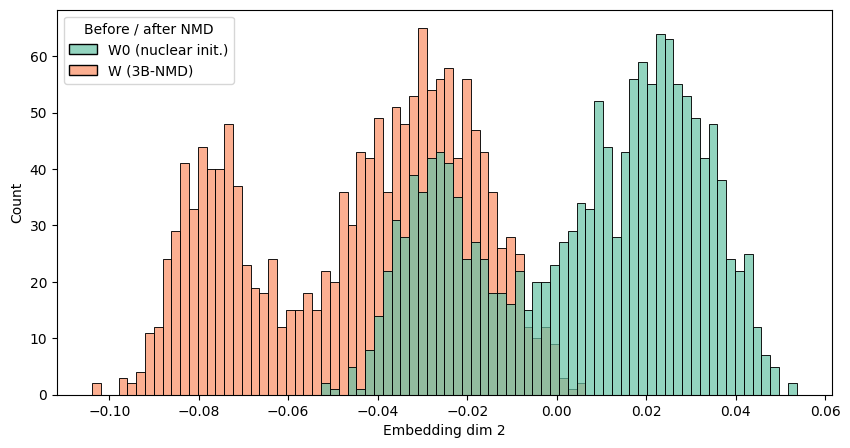

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
histogram_W0_dim2_nuclear_vs_W_nmd_r1 = sns.histplot(
    data=df_histogram_W0nuclear_vs_W_nmd_r1,
    x="dim_2",
    hue="W0_W_nmd",
    bins=80,
    alpha=0.7,
    palette="Set2",
)
histogram_W0_dim2_nuclear_vs_W_nmd_r1.legend_.set_title("Before / after NMD")
ax.set_xlabel("Embedding dim 2")

plt.savefig(f"{figure_path}/histogram_W0_dim2_nuclear_vs_W_nmd.svg", format="svg")
plt.show()

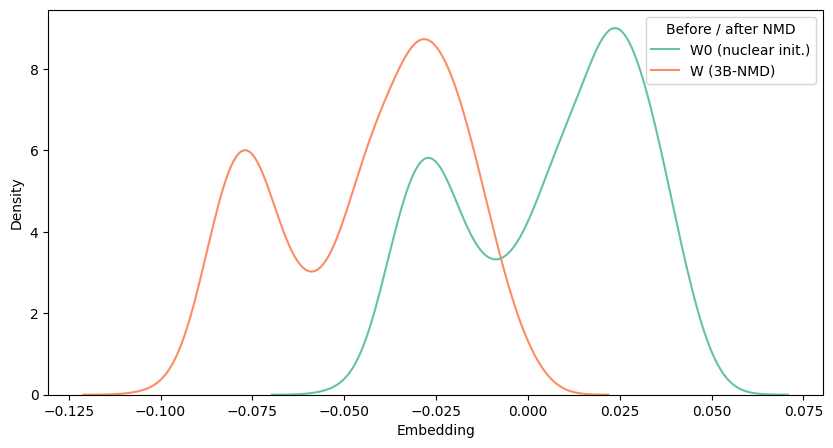

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
kdeplot_W0_dim2_nuclear_vs_W_nmd_r1 = sns.kdeplot(
    data=df_histogram_W0nuclear_vs_W_nmd_r1, x="dim_2", hue="W0_W_nmd", palette="Set2"
)
kdeplot_W0_dim2_nuclear_vs_W_nmd_r1.legend_.set_title("Before / after NMD")
ax.set_xlabel("Embedding")

plt.savefig(f"{figure_path}/kdeplot_W0_dim2_nuclear_vs_W_nmd.svg", format="svg")
plt.show()

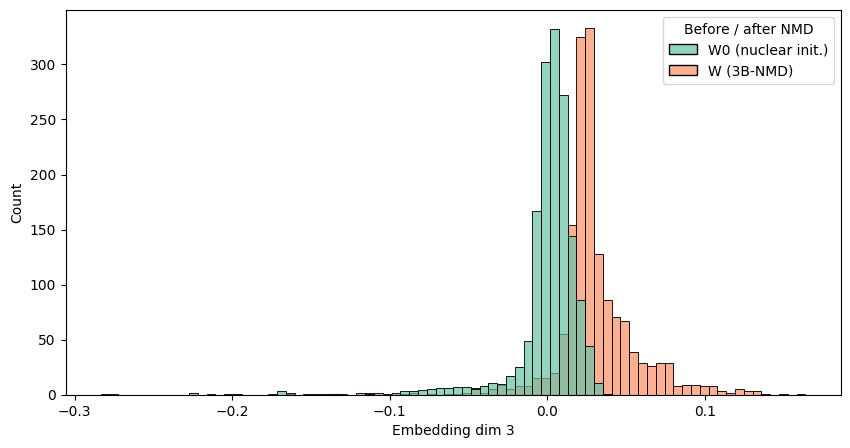

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
histogram_W0_dim2_nuclear_vs_W_nmd_r1 = sns.histplot(
    data=df_histogram_W0nuclear_vs_W_nmd_r1,
    x="dim_3",
    hue="W0_W_nmd",
    bins=80,
    alpha=0.7,
    palette="Set2",
)
histogram_W0_dim2_nuclear_vs_W_nmd_r1.legend_.set_title("Before / after NMD")
ax.set_xlabel("Embedding dim 3")

plt.savefig(f"{figure_path}/histogram_W0_dim3_nuclear_vs_W_nmd.svg", format="svg")
plt.show()

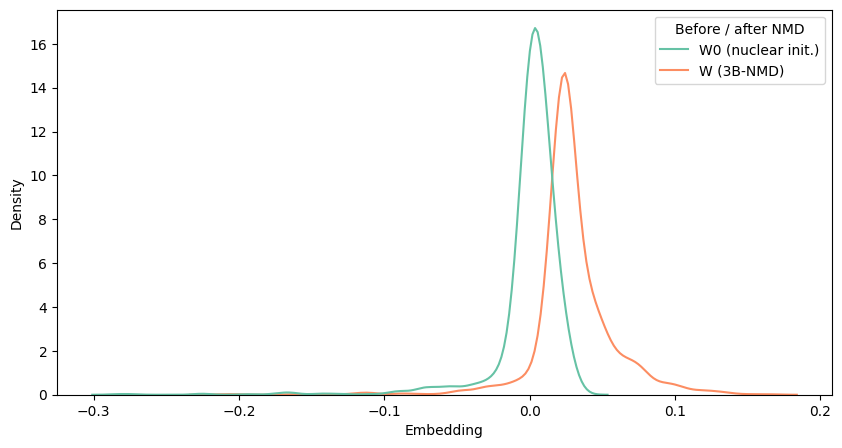

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
kdeplot_W0_dim2_nuclear_vs_W_nmd_r1 = sns.kdeplot(
    data=df_histogram_W0nuclear_vs_W_nmd_r1, x="dim_3", hue="W0_W_nmd", palette="Set2"
)
kdeplot_W0_dim2_nuclear_vs_W_nmd_r1.legend_.set_title("Before / after NMD")
ax.set_xlabel("Embedding")

plt.savefig(f"{figure_path}/kdeplot_W0_dim3_nuclear_vs_W_nmd.svg", format="svg")
plt.show()

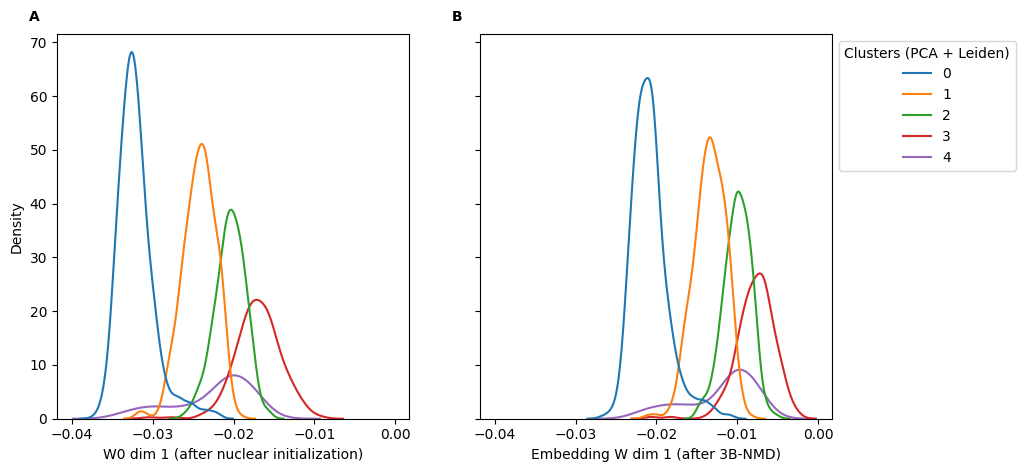

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=[10, 5])
sns.kdeplot(
    x=W0[:, 0:1].flatten(), hue=data.obs["leiden_opt_PCA"], ax=ax1, legend=False
)
ax1.set_xlabel("W0 dim 1 (after nuclear initialization)")
trans = mtransforms.ScaledTranslation(-20 / 72, 7 / 72, fig.dpi_scale_trans)
ax1.text(
    0.0,
    1.0,
    "A",
    transform=ax1.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)

sns.kdeplot(
    x=data.obsm["X_nmd"][:, 0:1].flatten(), hue=data.obs["leiden_opt_PCA"], ax=ax2
).axes.legend_.set_title("Clusters (PCA + Leiden)")
ax2.set_xlabel("Embedding W dim 1 (after 3B-NMD)")
ax2.text(
    0.0,
    1.0,
    "B",
    transform=ax2.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))


plt.savefig(
    f"{figure_path}/kde_W0_dim1_nuclear_vs_W_nmd_by_pca_cluster.svg", format="svg"
)
plt.show()

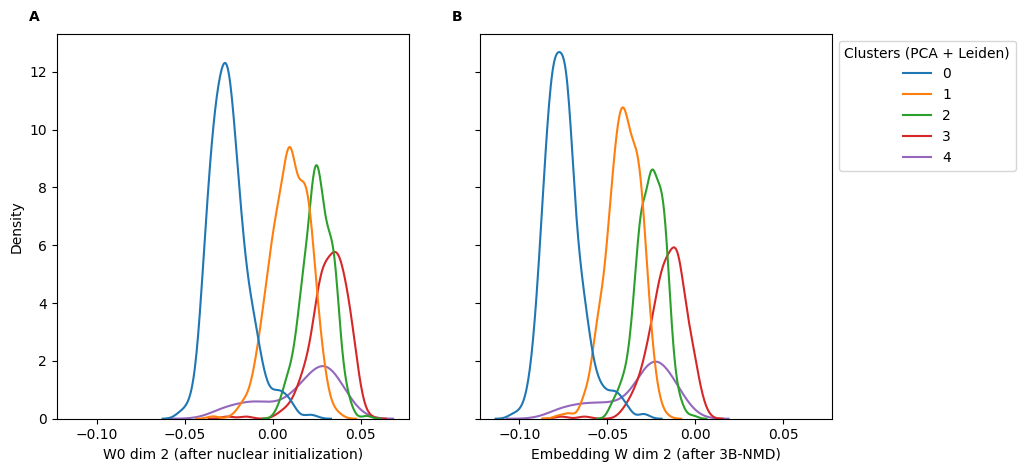

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=[10, 5])
sns.kdeplot(
    x=W0[:, 1:2].flatten(), hue=data.obs["leiden_opt_PCA"], ax=ax1, legend=False
)
ax1.set_xlabel("W0 dim 2 (after nuclear initialization)")
trans = mtransforms.ScaledTranslation(-20 / 72, 7 / 72, fig.dpi_scale_trans)
ax1.text(
    0.0,
    1.0,
    "A",
    transform=ax1.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)

sns.kdeplot(
    x=data.obsm["X_nmd"][:, 1:2].flatten(), hue=data.obs["leiden_opt_PCA"], ax=ax2
).axes.legend_.set_title("Clusters (PCA + Leiden)")
ax2.set_xlabel("Embedding W dim 2 (after 3B-NMD)")
ax2.text(
    0.0,
    1.0,
    "B",
    transform=ax2.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))

plt.savefig(
    f"{figure_path}/kde_W0_dim2_nuclear_vs_W_nmd_by_pca_cluster.svg", format="svg"
)
plt.show()

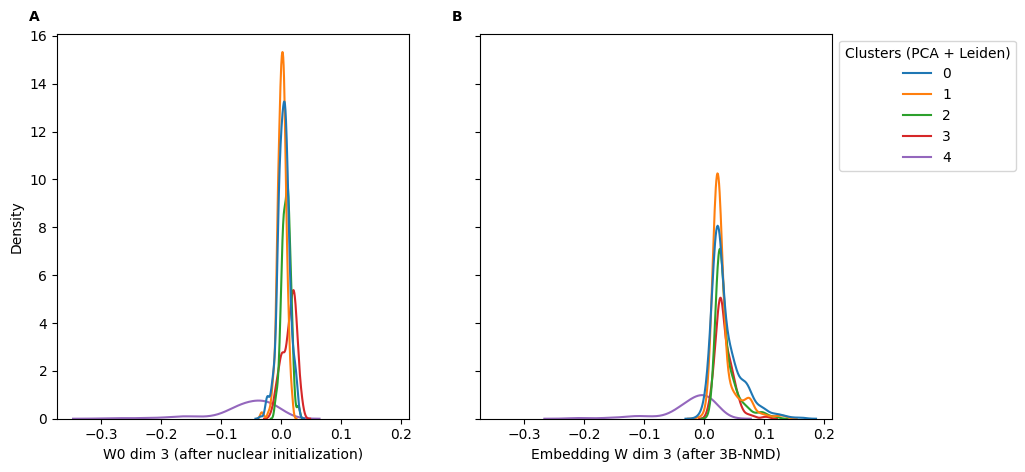

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=[10, 5])
sns.kdeplot(
    x=W0[:, 2:3].flatten(), hue=data.obs["leiden_opt_PCA"], ax=ax1, legend=False
)
ax1.set_xlabel("W0 dim 3 (after nuclear initialization)")
trans = mtransforms.ScaledTranslation(-20 / 72, 7 / 72, fig.dpi_scale_trans)
ax1.text(
    0.0,
    1.0,
    "A",
    transform=ax1.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)

sns.kdeplot(
    x=data.obsm["X_nmd"][:, 2:3].flatten(), hue=data.obs["leiden_opt_PCA"], ax=ax2
).axes.legend_.set_title("Clusters (PCA + Leiden)")
ax2.set_xlabel("Embedding W dim 3 (after 3B-NMD)")
ax2.text(
    0.0,
    1.0,
    "B",
    transform=ax2.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))

plt.savefig(
    f"{figure_path}/kde_W0_dim3_nuclear_vs_W_nmd_by_pca_cluster.svg", format="svg"
)
plt.show()

#### NMD embeddings vs. sequencing depth

Plot embeddings colored by sequencing depth.

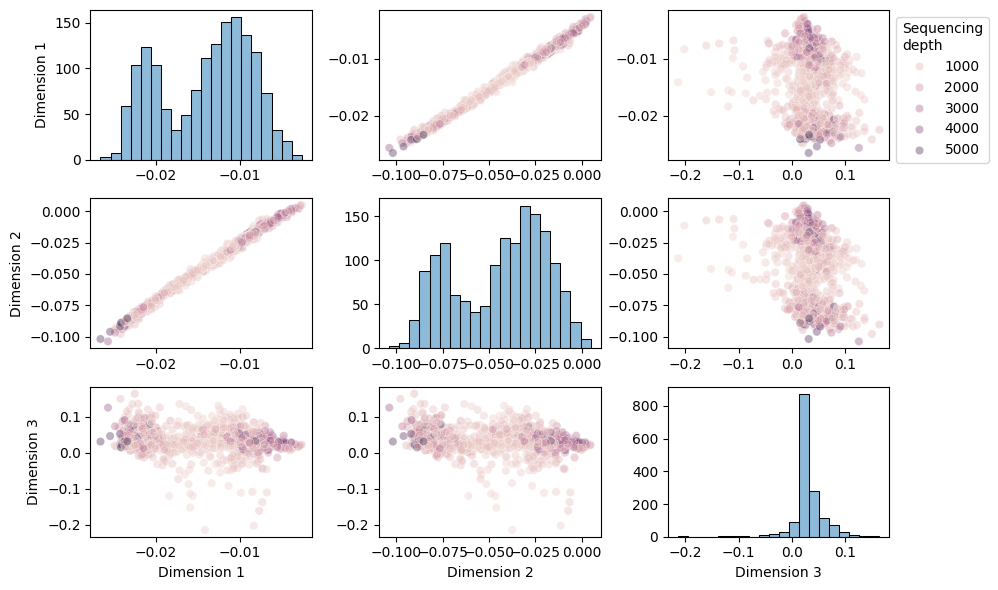

In [27]:
embeddings_2_plot = data.obsm["X_nmd"]
_, p = embeddings_2_plot.shape

fig, axs = plt.subplots(p, p, figsize=[10, 6], sharex=False)

hist_y_lim = [0, 250]
hist_bins = 20

scatter_lim = [embeddings_2_plot.min() - 0.01, embeddings_2_plot.max() + 0.01]
scatter_alpha = 0.4
scatter_hue = data.obs["total_counts"]

for i, row in enumerate(axs):
    for j, axis in enumerate(row):
        if i == j:  # histogram
            sns.histplot(
                embeddings_2_plot[:, i : (i + 1)], ax=axis, legend=False, bins=hist_bins
            )
        else:
            use_legend = (i == 0 and j == (p - 1)) and (scatter_hue is not None)
            sns.scatterplot(
                y=embeddings_2_plot[:, i : (i + 1)].flatten(),
                x=embeddings_2_plot[:, j : (j + 1)].flatten(),
                alpha=scatter_alpha,
                hue=scatter_hue,
                ax=axis,
                legend=use_legend,
            )
            if use_legend:
                sns.move_legend(axis, "upper left", bbox_to_anchor=(1, 1))
                axis.legend_.set_title("Sequencing\ndepth")
        if j == 0:
            axis.set_ylabel(f"Dimension {i + 1}")
        else:
            axis.set_ylabel(None)
        if i == len(row) - 1:
            axis.set_xlabel(f"Dimension {j + 1}")
        else:
            axis.set_xlabel(None)

plt.tight_layout()
plt.savefig(f"{figure_path}/embedding_plot_nmd_count_r2_hueSeqDepth.svg", format="svg")
plt.show()

Embeddings dimensions (separately) vs. sequencing depth.

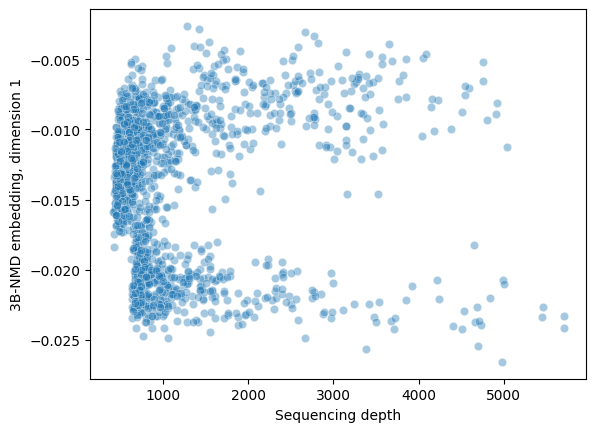

In [28]:
scatter_seqdepth_nmd_dim1 = sns.scatterplot(
    y=data.obsm["X_nmd"][:, 0:1].flatten(), x=data.obs["total_counts"], alpha=0.4
)
plt.ylabel("3B-NMD embedding, dimension 1")
plt.xlabel("Sequencing depth")


plt.savefig(f"{figure_path}/scatter_seqdepth_nmd_dim1.svg", format="svg")
plt.show()

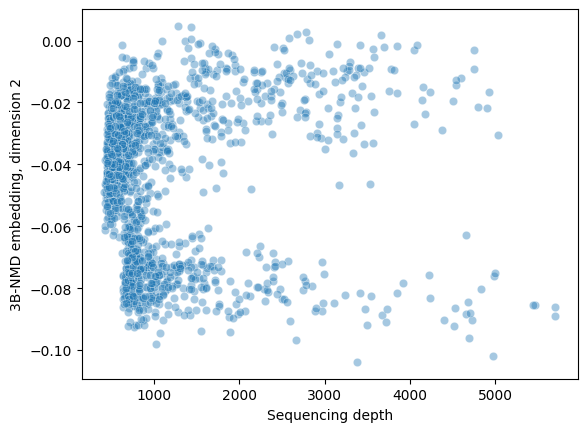

In [29]:
scatter_seqdepth_nmd_dim2 = sns.scatterplot(
    y=data.obsm["X_nmd"][:, 1:2].flatten(), x=data.obs["total_counts"], alpha=0.4
)
plt.ylabel("3B-NMD embedding, dimension 2")
plt.xlabel("Sequencing depth")


plt.savefig(f"{figure_path}/scatter_seqdepth_nmd_dim2.svg", format="svg")
plt.show()

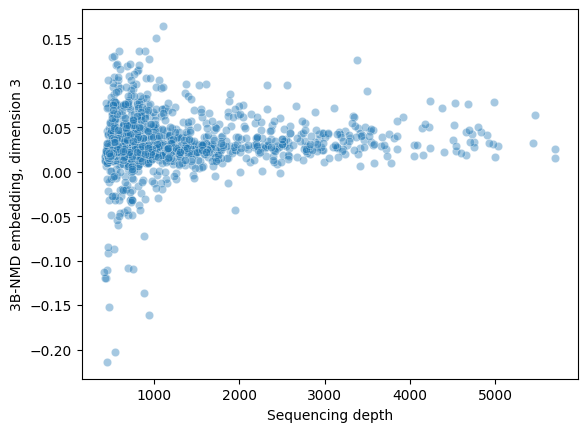

In [30]:
scatter_seqdepth_nmd_dim2 = sns.scatterplot(
    y=data.obsm["X_nmd"][:, 2:3].flatten(), x=data.obs["total_counts"], alpha=0.4
)
plt.ylabel("3B-NMD embedding, dimension 3")
plt.xlabel("Sequencing depth")


plt.savefig(f"{figure_path}/scatter_seqdepth_nmd_dim3.svg", format="svg")
plt.show()

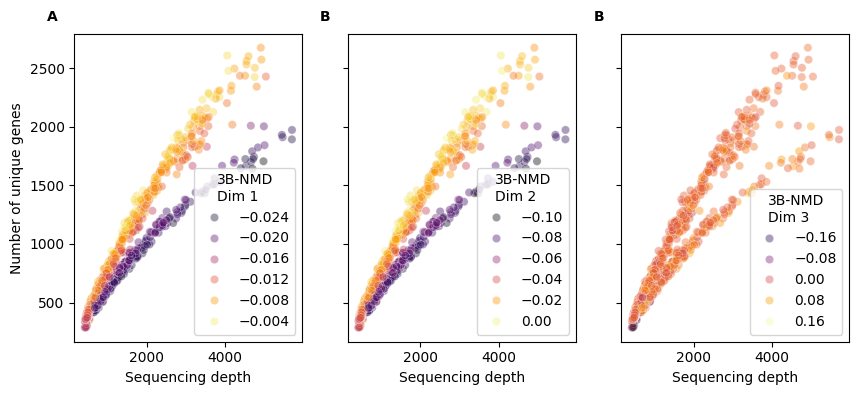

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[10, 4], sharex=True, sharey=True)
sns.scatterplot(
    x=data.obs["total_counts"],
    y=data.obs["n_genes_by_counts"],
    hue=data.obsm["X_nmd"][:, :1].flatten(),
    alpha=0.4,
    palette="inferno",
    ax=ax1,
)
ax1.set_ylabel("Number of unique genes")
ax1.set_xlabel("Sequencing depth")
ax1.legend_.set_title("3B-NMD\nDim 1")
trans = mtransforms.ScaledTranslation(-20 / 72, 7 / 72, fig.dpi_scale_trans)
ax1.text(
    0.0,
    1.0,
    "A",
    transform=ax1.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)

sns.scatterplot(
    x=data.obs["total_counts"],
    y=data.obs["n_genes_by_counts"],
    hue=data.obsm["X_nmd"][:, 1:2].flatten(),
    alpha=0.4,
    palette="inferno",
    ax=ax2,
)
ax2.set_ylabel(None)
ax2.set_xlabel("Sequencing depth")
ax2.legend_.set_title("3B-NMD\nDim 2")
ax2.text(
    0.0,
    1.0,
    "B",
    transform=ax2.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)

sns.scatterplot(
    x=data.obs["total_counts"],
    y=data.obs["n_genes_by_counts"],
    hue=data.obsm["X_nmd"][:, 2:3].flatten(),
    alpha=0.4,
    palette="inferno",
    ax=ax3,
)
ax3.set_ylabel(None)
ax3.set_xlabel("Sequencing depth")
ax3.legend_.set_title("3B-NMD\nDim 3")
ax3.text(
    0.0,
    1.0,
    "B",
    transform=ax3.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)
plt.savefig(f"{figure_path}/sequencingdepth_uniquegenes_hueNMD.svg", format="svg")
plt.show()

#### NMD "components" vs. mean counts

NMD "components" are `p x k`, where `p` is the number of columns in the original data and `k` is the number of NMD latent dimensions.

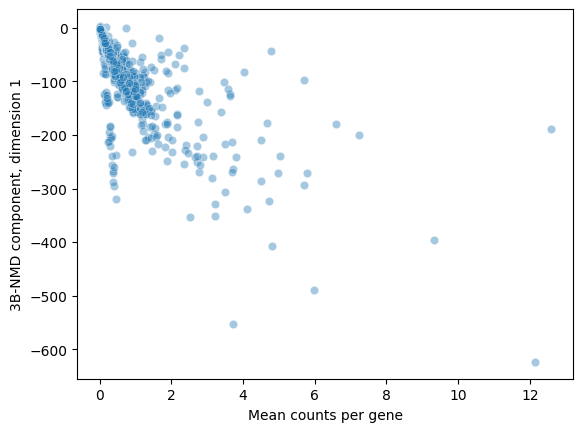

In [32]:
scatter_seqdepth_nmd_dim1 = sns.scatterplot(
    y=data.varm["nmd_components"][:, 0:1].flatten(),
    x=data.var["mean_counts"],
    alpha=0.4,
)
plt.ylabel("3B-NMD component, dimension 1")
plt.xlabel("Mean counts per gene")


plt.savefig(f"{figure_path}/scatter_mean_counts_nmd_comp1.svg", format="svg")
plt.show()

In [33]:
corr_comp2_meancountspergene = np.corrcoef(
    data.varm["nmd_components"][:, 0:1].flatten(), data.var["mean_counts"]
)[0][1]

print(
    f"Correlation between embedding component 1 and mean counts per gene: {corr_comp2_meancountspergene:.3f}"
)

Correlation between embedding component 1 and mean counts per gene: -0.769


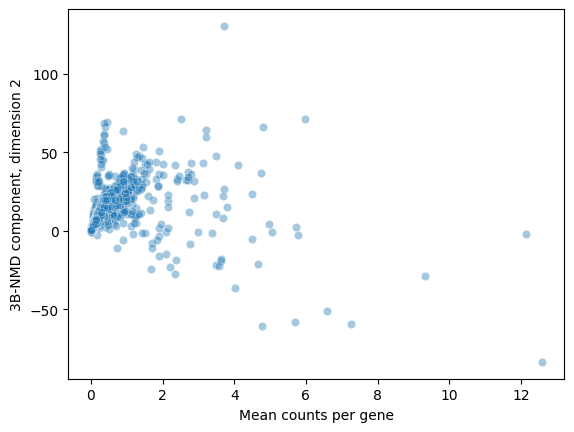

In [34]:
scatter_seqdepth_nmd_dim1 = sns.scatterplot(
    y=data.varm["nmd_components"][:, 1:2].flatten(),
    x=data.var["mean_counts"],
    alpha=0.4,
)
plt.ylabel("3B-NMD component, dimension 2")
plt.xlabel("Mean counts per gene")


plt.savefig(f"{figure_path}/scatter_mean_counts_nmd_comp2.svg", format="svg")
plt.show()

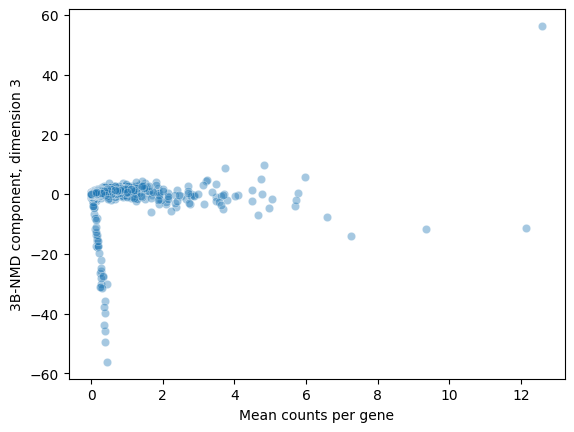

In [35]:
scatter_seqdepth_nmd_dim3 = sns.scatterplot(
    y=data.varm["nmd_components"][:, 2:3].flatten(),
    x=data.var["mean_counts"],
    alpha=0.4,
)
plt.ylabel("3B-NMD component, dimension 3")
plt.xlabel("Mean counts per gene")


plt.savefig(f"{figure_path}/scatter_mean_counts_nmd_comp3.svg", format="svg")
plt.show()

#### NMD embeddings vs. PCs

Colored by clustering found using PCA + Leiden

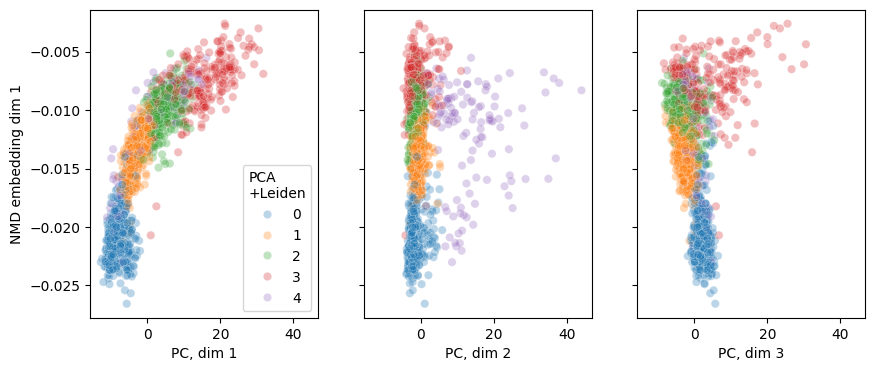

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[10, 4], sharex=True, sharey=True)
sns.scatterplot(
    y=data.obsm["X_nmd"][:, 0:1].flatten(),
    x=data.obsm["X_pca"][:, 0:1].flatten(),
    alpha=0.3,
    hue=data.obs["leiden_opt_PCA"],
    ax=ax1,
)
ax1.set_xlabel("PC, dim 1")
ax1.set_ylabel("NMD embedding dim 1")
ax1.legend_.set_title("PCA\n+Leiden")

sns.scatterplot(
    y=data.obsm["X_nmd"][:, 0:1].flatten(),
    x=data.obsm["X_pca"][:, 1:2].flatten(),
    alpha=0.3,
    hue=data.obs["leiden_opt_PCA"],
    ax=ax2,
)
ax2.set_xlabel("PC, dim 2")
ax2.legend_.set_visible(None)

sns.scatterplot(
    y=data.obsm["X_nmd"][:, 0:1].flatten(),
    x=data.obsm["X_pca"][:, 2:3].flatten(),
    alpha=0.3,
    hue=data.obs["leiden_opt_PCA"],
    ax=ax3,
)
ax3.set_xlabel("PC, dim 3")
ax3.legend_.set_visible(None)

plt.show()

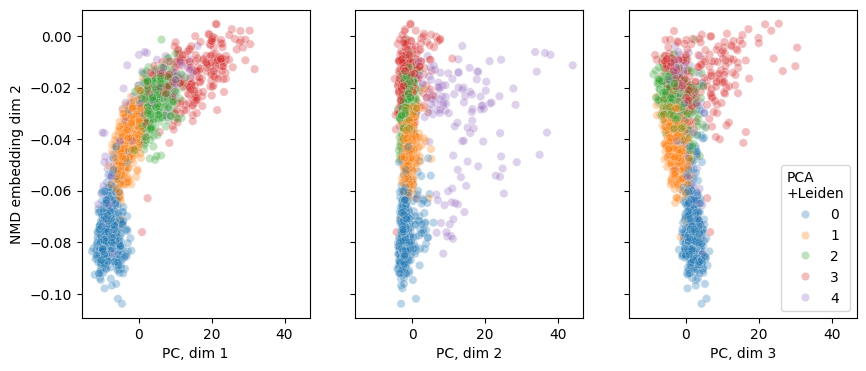

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[10, 4], sharex=True, sharey=True)
sns.scatterplot(
    y=data.obsm["X_nmd"][:, 1:2].flatten(),
    x=data.obsm["X_pca"][:, 0:1].flatten(),
    alpha=0.3,
    hue=data.obs["leiden_opt_PCA"],
    ax=ax1,
)
ax1.set_xlabel("PC, dim 1")
ax1.set_ylabel("NMD embedding dim 2")
ax1.legend_.set_visible(None)

sns.scatterplot(
    y=data.obsm["X_nmd"][:, 1:2].flatten(),
    x=data.obsm["X_pca"][:, 1:2].flatten(),
    alpha=0.3,
    hue=data.obs["leiden_opt_PCA"],
    ax=ax2,
)
ax2.set_xlabel("PC, dim 2")
ax2.legend_.set_visible(None)

sns.scatterplot(
    y=data.obsm["X_nmd"][:, 1:2].flatten(),
    x=data.obsm["X_pca"][:, 2:3].flatten(),
    alpha=0.3,
    hue=data.obs["leiden_opt_PCA"],
    ax=ax3,
)
ax3.set_xlabel("PC, dim 3")
ax3.legend_.set_title("PCA\n+Leiden")

plt.show()

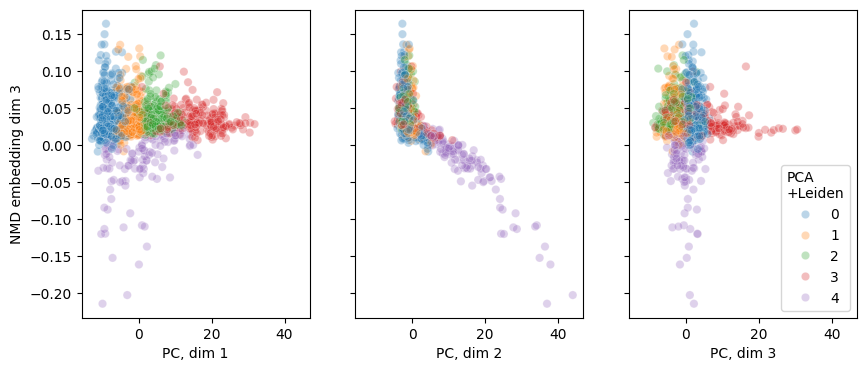

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[10, 4], sharex=True, sharey=True)
sns.scatterplot(
    y=data.obsm["X_nmd"][:, 2:3].flatten(),
    x=data.obsm["X_pca"][:, 0:1].flatten(),
    alpha=0.3,
    hue=data.obs["leiden_opt_PCA"],
    ax=ax1,
)
ax1.set_xlabel("PC, dim 1")
ax1.set_ylabel("NMD embedding dim 3")
ax1.legend_.set_visible(None)

sns.scatterplot(
    y=data.obsm["X_nmd"][:, 2:3].flatten(),
    x=data.obsm["X_pca"][:, 1:2].flatten(),
    alpha=0.3,
    hue=data.obs["leiden_opt_PCA"],
    ax=ax2,
)
ax2.set_xlabel("PC, dim 2")
ax2.legend_.set_visible(None)

sns.scatterplot(
    y=data.obsm["X_nmd"][:, 2:3].flatten(),
    x=data.obsm["X_pca"][:, 2:3].flatten(),
    alpha=0.3,
    hue=data.obs["leiden_opt_PCA"],
    ax=ax3,
)
ax3.set_xlabel("PC, dim 3")
ax3.legend_.set_title("PCA\n+Leiden")

plt.show()

#### NMD embeddings vs. PCA + Leiden clustering

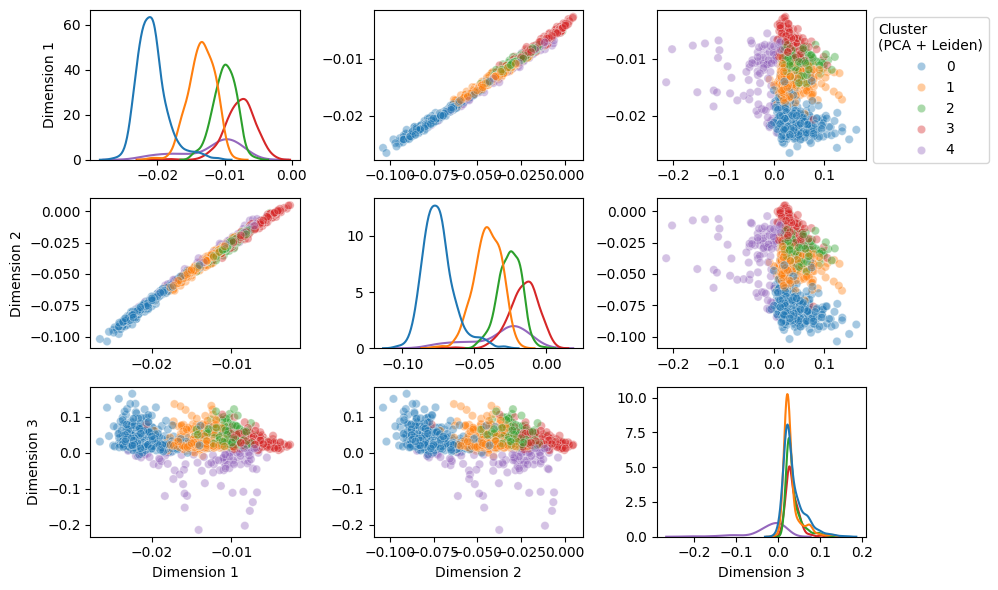

In [39]:
embeddings_2_plot = data.obsm["X_nmd"]
_, p = embeddings_2_plot.shape

fig, axs = plt.subplots(p, p, figsize=[10, 6], sharex=False)

hist_y_lim = [0, 250]
hist_bins = 20

scatter_lim = [embeddings_2_plot.min() - 0.01, embeddings_2_plot.max() + 0.01]
scatter_alpha = 0.4

scatter_hue = data.obs["leiden_opt_PCA"]


for i, row in enumerate(axs):
    for j, axis in enumerate(row):
        if i == j:
            sns.kdeplot(
                x=embeddings_2_plot[:, i : (i + 1)].flatten(),
                ax=axis,
                legend=False,
                hue=scatter_hue,
            )
        else:
            use_legend = (i == 0 and j == (p - 1)) and (scatter_hue is not None)
            sns.scatterplot(
                y=embeddings_2_plot[:, i : (i + 1)].flatten(),
                x=embeddings_2_plot[:, j : (j + 1)].flatten(),
                alpha=scatter_alpha,
                hue=scatter_hue,
                ax=axis,
                legend=use_legend,
            )
            if use_legend:
                sns.move_legend(axis, "upper left", bbox_to_anchor=(1, 1))
                axis.legend_.set_title("Cluster\n(PCA + Leiden)")
        if j == 0:
            axis.set_ylabel(f"Dimension {i + 1}")
        else:
            axis.set_ylabel(None)
        if i == len(row) - 1:
            axis.set_xlabel(f"Dimension {j + 1}")
        else:
            axis.set_xlabel(None)

plt.tight_layout()


plt.savefig(
    f"{figure_path}/embedding_plot_nmd_count_r2_huePCACluster_kde.svg", format="svg"
)
plt.show()

## UMAP: Selection of optimal number of neighbors and optimal scale via scDEED

In [40]:
n_neighbors = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250]
min_dists = [0.05, 0.1, 0.3, 0.5, 0.7]

In [41]:
importlib.reload(scd)

<module 'tools.scDEED' from '/Users/stffn/projects/thesis_dev/msc_thesis/application/tools/scDEED.py'>

In [45]:
n_neighbors_opt = 25
min_dist_opt = 0.1

data.uns["BacSC_params_NMD"]["n_neighbors_opt"] = n_neighbors_opt
data.uns["BacSC_params_NMD"]["min_dist_opt"] = min_dist_opt

In [43]:
(
    scdeed_result,
    rel_scores,
    null_rel_scores,
    reliabilities,
    n_neighbors_opt,
    min_dist_opt,
) = scd.scdeed_parameter_selection(
    data,
    n_neighbors,
    min_dists,
    n_pcs=k_opt,
    rng_seed=674116985,
    layer="normalized_counts",
    dim_red_method="3B-NMD",
    dim_red_params={"beta1": beta_opt},
    obsm_embedding_key="X_nmd",
    embedding_method="UMAP",
    similarity_percent=0.5,
    save_path=f"{data_path}/S3_filtered_scdeed_nmd_normalized_counts_r3",
)

calculating (10, 0.05) - run 1/85


INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None
INFO:fi_nomad.entry:300 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 6.126699736341834e-05 loop took 65.71778123200056 overall (0.2190592707733352/ea)


calculating (10, 0.1) - run 2/85
calculating (10, 0.3) - run 3/85
calculating (10, 0.5) - run 4/85
calculating (10, 0.7) - run 5/85
calculating (15, 0.05) - run 6/85
calculating (15, 0.1) - run 7/85
calculating (15, 0.3) - run 8/85
calculating (15, 0.5) - run 9/85
calculating (15, 0.7) - run 10/85
calculating (20, 0.05) - run 11/85
calculating (20, 0.1) - run 12/85
calculating (20, 0.3) - run 13/85
calculating (20, 0.5) - run 14/85
calculating (20, 0.7) - run 15/85
calculating (25, 0.05) - run 16/85
calculating (25, 0.1) - run 17/85
calculating (25, 0.3) - run 18/85
calculating (25, 0.5) - run 19/85
calculating (25, 0.7) - run 20/85
calculating (30, 0.05) - run 21/85
calculating (30, 0.1) - run 22/85
calculating (30, 0.3) - run 23/85
calculating (30, 0.5) - run 24/85
calculating (30, 0.7) - run 25/85
calculating (35, 0.05) - run 26/85
calculating (35, 0.1) - run 27/85
calculating (35, 0.3) - run 28/85
calculating (35, 0.5) - run 29/85
calculating (35, 0.7) - run 30/85
calculating (40, 

Optimal number of neighbors: 25
Optimal min_dist: 0.1


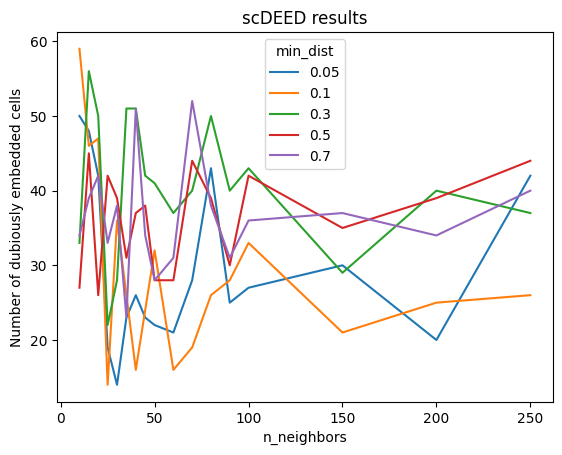

In [44]:
print(f"Optimal number of neighbors: {n_neighbors_opt}")
print(f"Optimal min_dist: {min_dist_opt}")

sns.lineplot(
    data=scdeed_result,
    x="n_neighbors",
    y="num_dubious",
    hue="min_dist",
    palette="tab10",
)
plt.title("scDEED results")
plt.ylabel("Number of dubiously embedded cells")
plt.show()

In [46]:
sc.pp.neighbors(
    data,
    n_neighbors=n_neighbors_opt,
    n_pcs=k_opt,
    key_added="NMD",
    use_rep="X_nmd",
)
sc.tl.umap(
    data,
    neighbors_key="NMD",
    min_dist=min_dist_opt,
    spread=1,
    random_state=9874516,
)

... storing 'embedding_reliability' as categorical


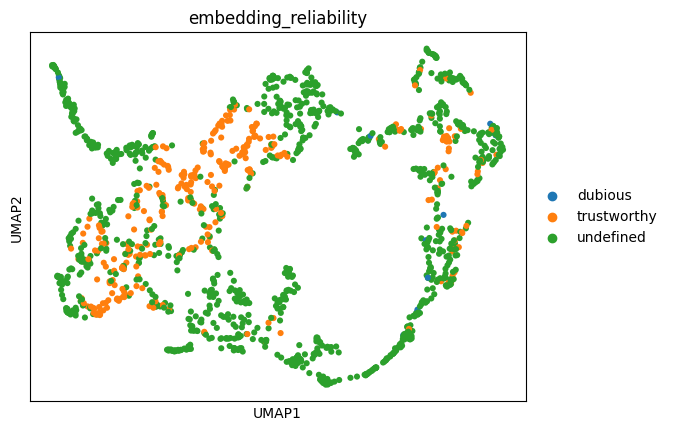

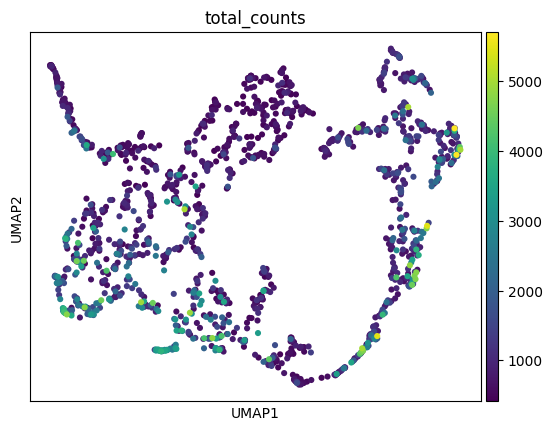

In [47]:
sc.pl.umap(
    data,
    color="embedding_reliability",
    alpha=1,
    layer="normalized_counts",
    neighbors_key="NMD",
)
plt.show()

sc.pl.umap(
    data,
    color="total_counts",
    alpha=1,
    cmap="viridis",
    layer="normalized_counts",
    neighbors_key="NMD",
)
plt.show()

## Clustering

Fit NMD on train and test data

In [49]:
data_train

AnnData object with n_obs × n_vars = 1544 × 5003
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt_PCA', 'n_counts', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std'
    layers: 'counts'

In [56]:
normalization_target_sum = data.obs["total_counts"].median()

In [57]:
data_train.X = data_train.layers["counts"].copy()
data_test.X = data_test.layers["counts"].copy()

# Normalizes X, such that: each barcode has total count equal to median of total counts before normalization
sc.pp.normalize_total(data_train, target_sum=normalization_target_sum, layer=None)
sc.pp.normalize_total(data_test, target_sum=normalization_target_sum, layer=None)

# Only normalization
data_train.layers["normalized_counts"] = data_train.X.copy()
data_test.layers["normalized_counts"] = data_test.X.copy()

In [58]:
X_train = ut.convert_to_dense(data_train, layer="normalized_counts")
X_train = X_train.astype(float)
m, n = X_train.shape
W0_train, H0_train = cs.nuclear_norm_init(X_train, m, n, int(k_opt))

X_test = ut.convert_to_dense(data_test, layer="normalized_counts")
X_test = X_test.astype(float)
W0_test, H0_test = cs.nuclear_norm_init(X_test, m, n, int(k_opt))

In [59]:
init_strat = InitializationStrategy.KNOWN_MATRIX
kernel_strat = KernelStrategy.MOMENTUM_3_BLOCK_MODEL_FREE

kernel_params_train = kernelInputTypes.Momentum3BlockAdditionalParameters(
    momentum_beta=beta_opt,
    candidate_factor_W0=W0_train,
    candidate_factor_H0=H0_train,
)

kernel_params_test = kernelInputTypes.Momentum3BlockAdditionalParameters(
    momentum_beta=beta_opt,
    candidate_factor_W0=W0_test,
    candidate_factor_H0=H0_test,
)

In [60]:
nmd_result_train = nmd.decompose(
    X_train,
    int(k_opt),
    kernel_strategy=kernel_strat,
    initialization=init_strat,
    kernel_params=kernel_params_train,
    manual_max_iterations=200,
    verbose=True,
    tolerance=None,
)

INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None
INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 7.380999159067869e-05 loop took 39.37380950700026 overall (0.1968690475350013/ea)


In [61]:
nmd_result_test = nmd.decompose(
    X_test,
    int(k_opt),
    kernel_strategy=kernel_strat,
    initialization=init_strat,
    kernel_params=kernel_params_test,
    manual_max_iterations=200,
    verbose=True,
    tolerance=None,
)

INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None
INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.265999839641154e-05 loop took 36.01383582100971 overall (0.18006917910504852/ea)


In [62]:
data_train.obsm["X_nmd"] = nmd_result_train.factors[0]
data_test.obsm["X_nmd"] = nmd_result_test.factors[0]

data_train.varm["nmd_components"] = nmd_result_train.factors[1].T
data_test.varm["nmd_components"] = nmd_result_test.factors[1].T

data_train.layers["Theta"] = nmd_result_train.factors[0] @ nmd_result_train.factors[1]
data_test.layers["Theta"] = nmd_result_test.factors[0] @ nmd_result_test.factors[1]

In [63]:
sc.pp.neighbors(
    data_train,
    n_neighbors=n_neighbors_opt,
    n_pcs=int(k_opt),
    use_rep="X_nmd",
    key_added="NMD",
)
sc.tl.umap(
    data_train, neighbors_key="NMD", min_dist=min_dist_opt, spread=1, random_state=1234
)

sc.pp.neighbors(
    data_test,
    n_neighbors=n_neighbors_opt,
    n_pcs=int(k_opt),
    use_rep="X_nmd",
    key_added="NMD",
)
sc.tl.umap(
    data_test, neighbors_key="NMD", min_dist=min_dist_opt, spread=1, random_state=1234
)

In [64]:
theta_opt, mirror_opt, umap_2_opt, ssd = ut.find_opt_umap_rotation(
    data_train.obsm["X_umap"].copy(), data_test.obsm["X_umap"].copy()
)
data_test.obsm["X_umap_rotated"] = umap_2_opt

In [65]:
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

In [67]:
co.cluster_train_test(
    data_train,
    data_test,
    resolutions,
    alg="leiden",
    neighbors_key="NMD",
    random_state=786469,
)

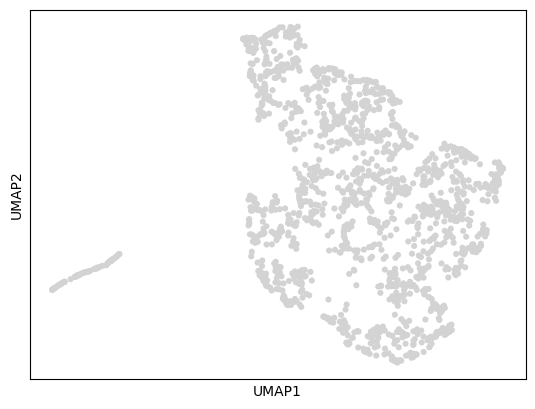

In [68]:
sc.pl.umap(data_train, neighbors_key="NMD")

In [71]:
res_opt = 0.29

In [72]:
data.uns["BacSC_params_NMD"]["res_opt"] = n_neighbors_opt

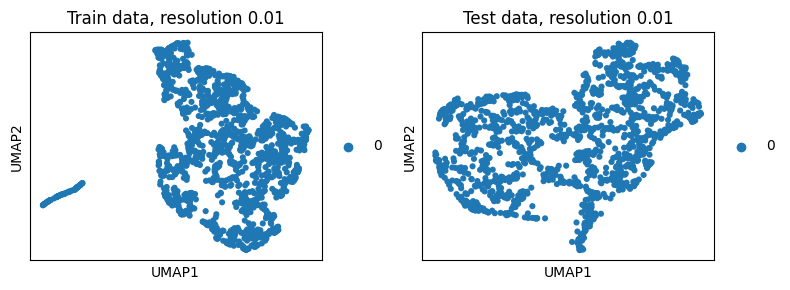

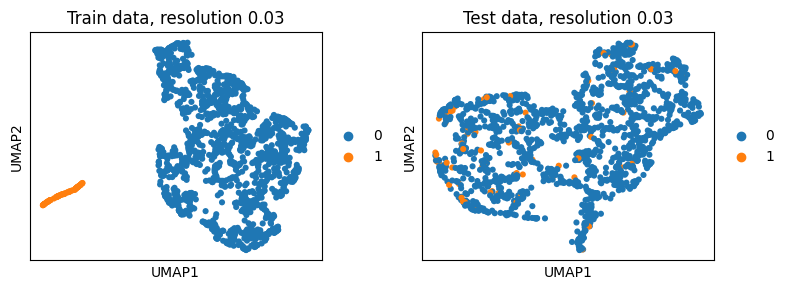

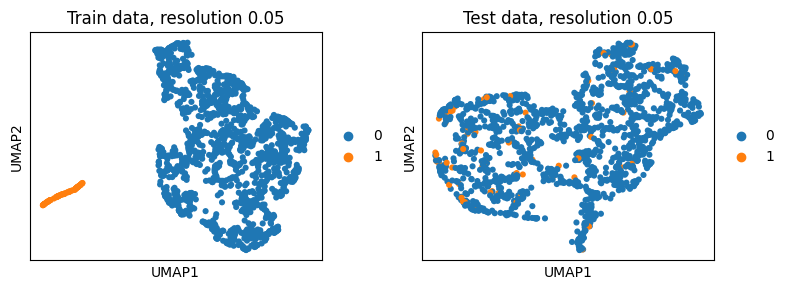

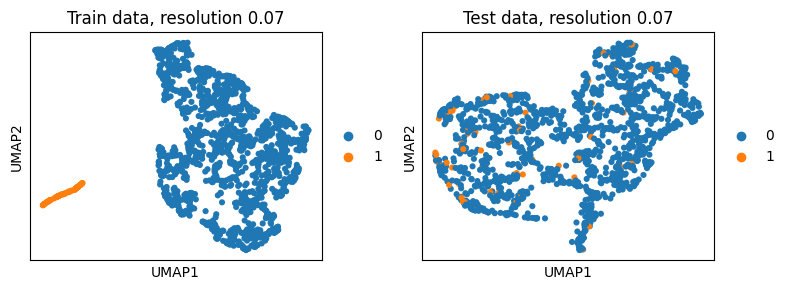

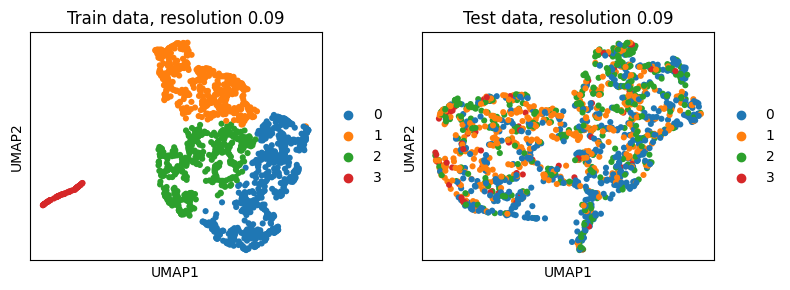

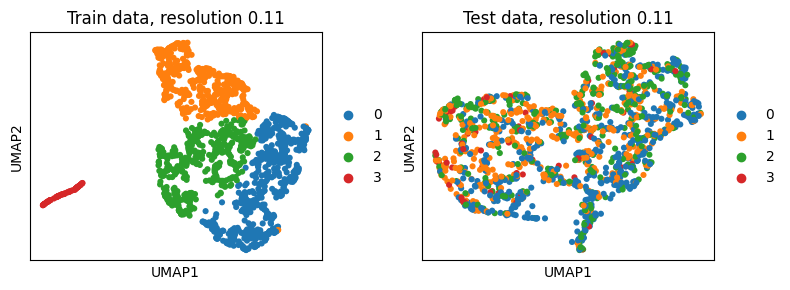

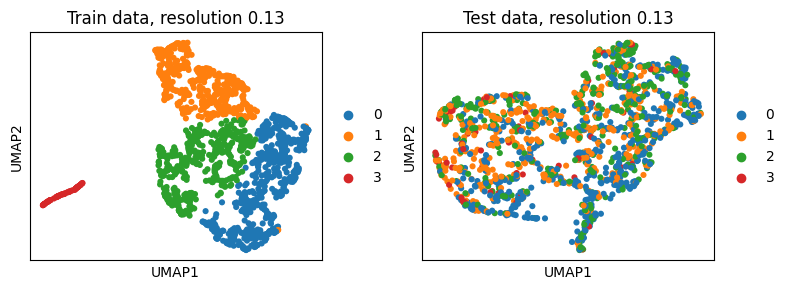

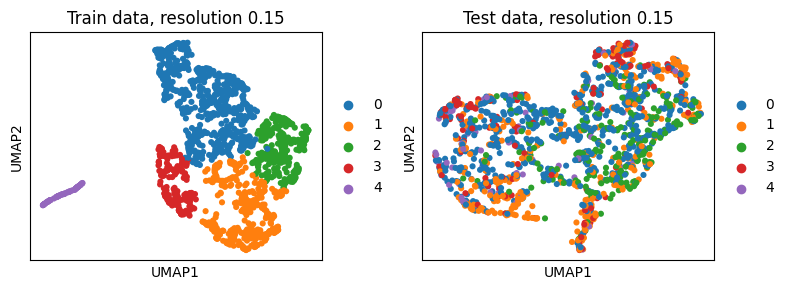

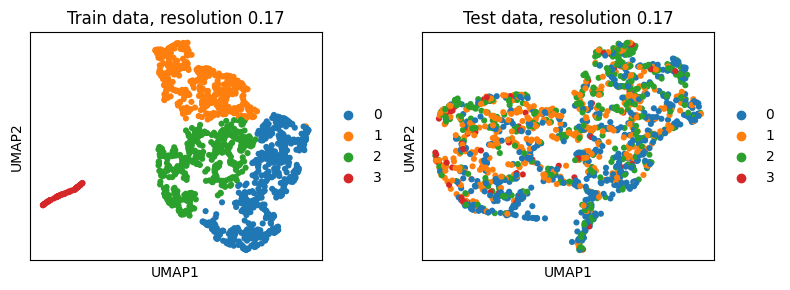

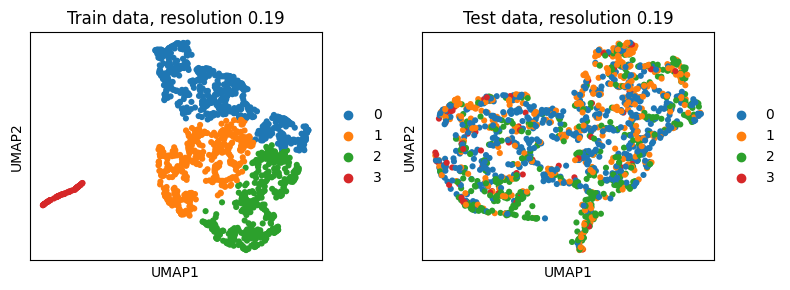

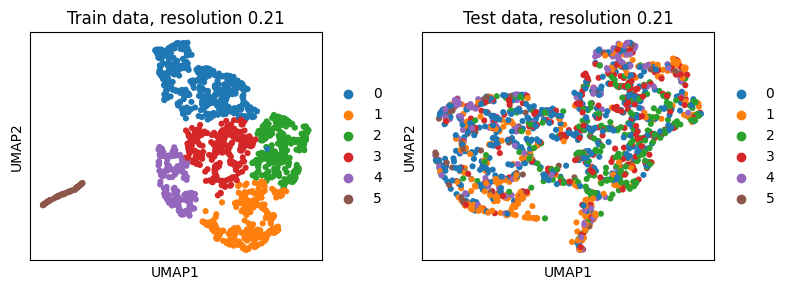

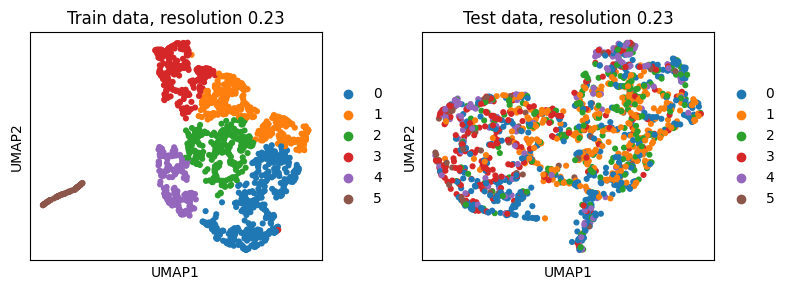

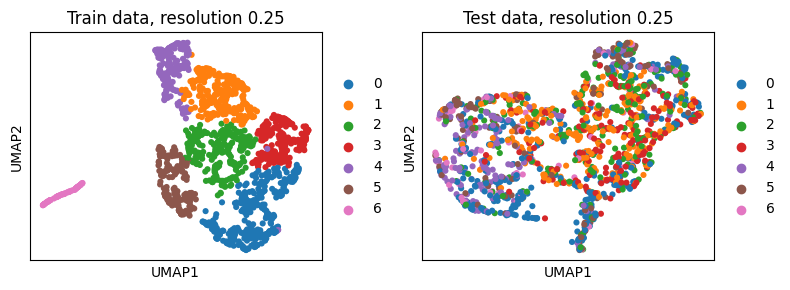

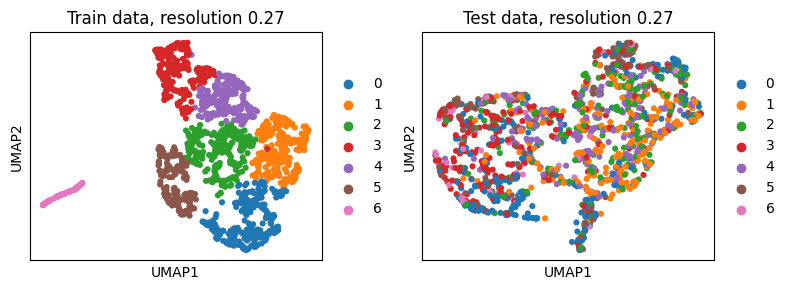

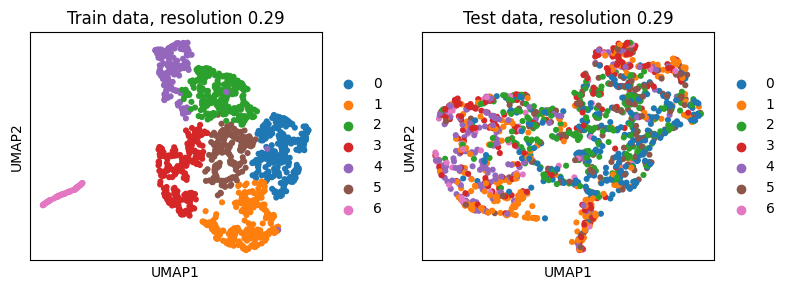

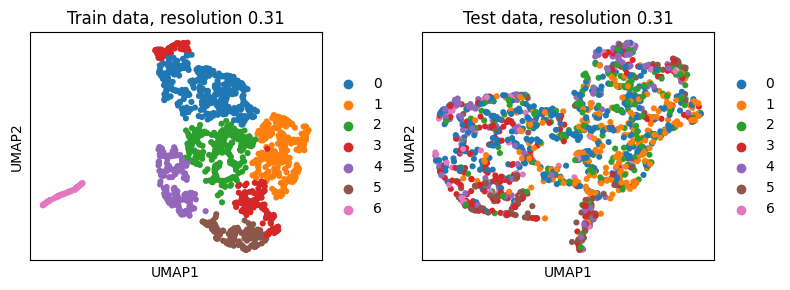

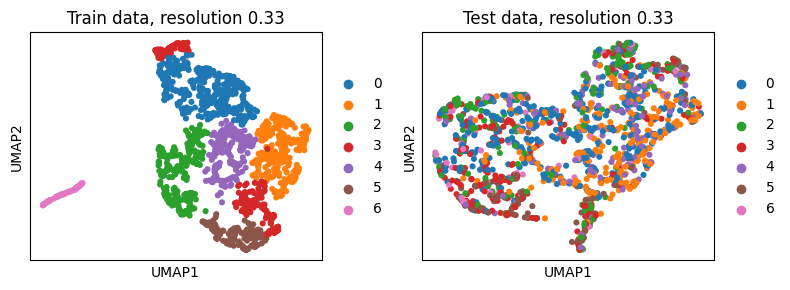

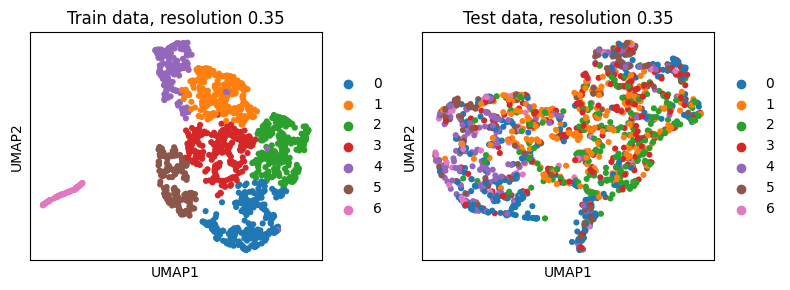

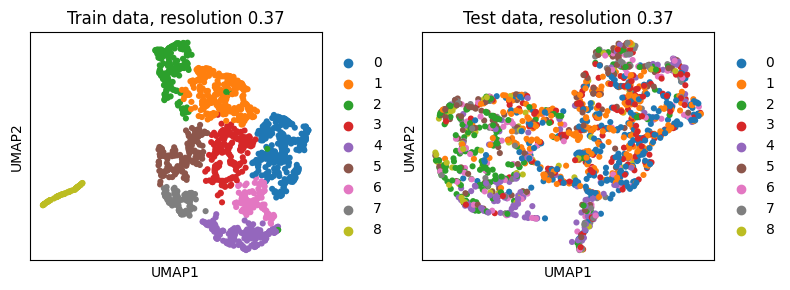

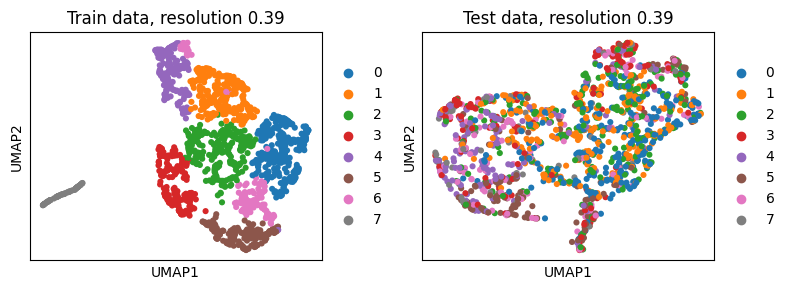

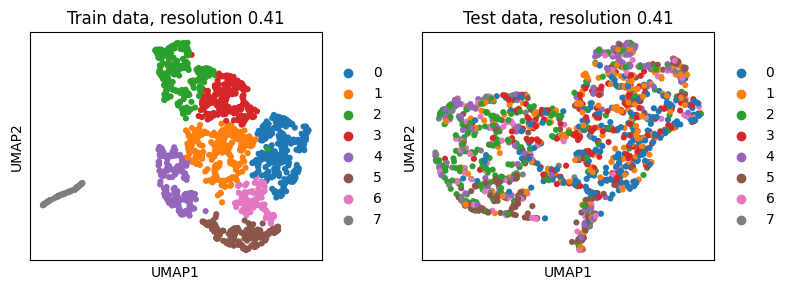

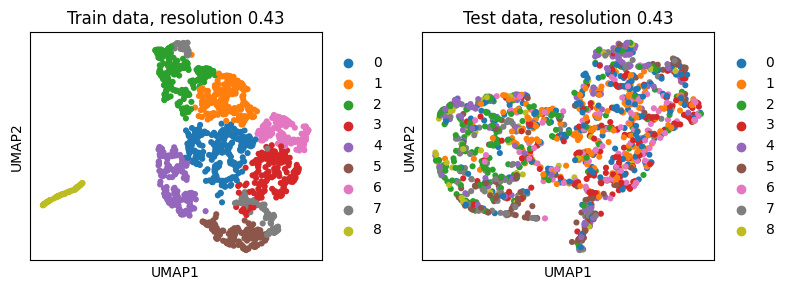

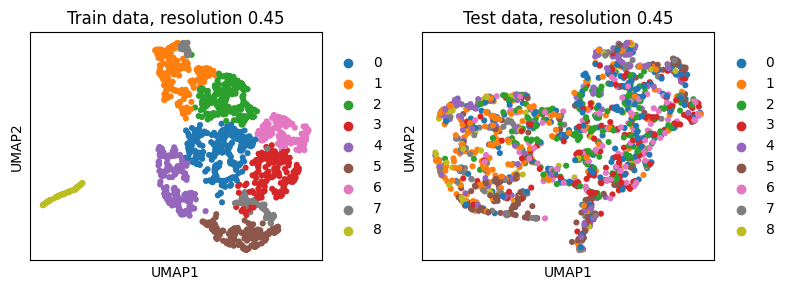

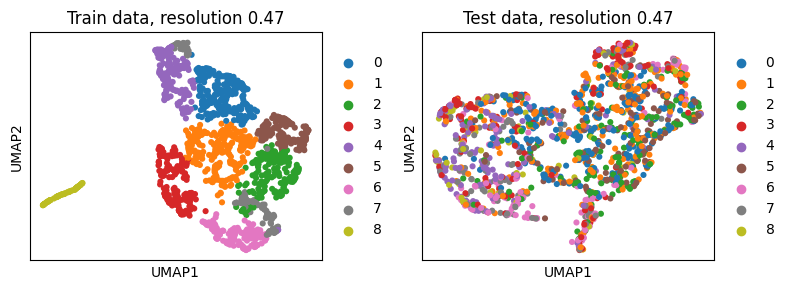

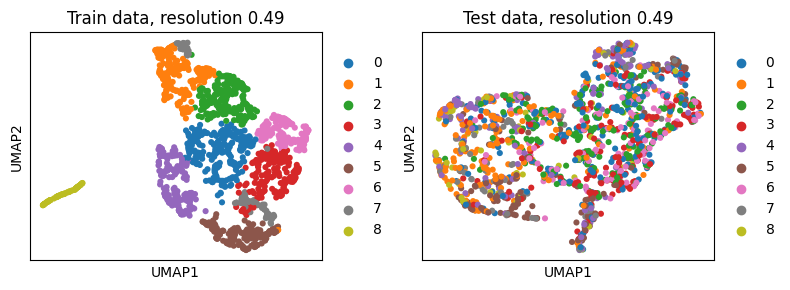

In [69]:
for resolution in resolutions:
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    sc.pl.umap(
        data_train,
        color=f"NMD_leiden_res{resolution}",
        ax=ax[0],
        title=f"Train data, resolution {resolution}",
        show=False,
        neighbors_key="NMD",
    )
    sc.pl.embedding(
        data_test,
        basis="X_umap_rotated",
        color=f"NMD_leiden_res{resolution}",
        ax=ax[1],
        title=f"Test data, resolution {resolution}",
        show=False,
        neighbors_key="NMD",
    )
    ax[1].set_xlabel("UMAP1")
    ax[1].set_ylabel("UMAP2")
    plt.tight_layout()
    plt.show()

In [70]:
importlib.reload(co)
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(
    data_train, data_test, resolutions, res_key="NMD_leiden_res", neighbors_key="NMD"
)

print(f"Optimal resolution {res_opt}")

resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 2 - Train: 0.47 - Test: 0.427 - Random: 0.427
resolution: 0.05 - clusters: 2 - Train: 0.452 - Test: 0.409 - Random: 0.409
resolution: 0.07 - clusters: 2 - Train: 0.434 - Test: 0.391 - Random: 0.39
resolution: 0.09 - clusters: 4 - Train: 0.434 - Test: 0.158 - Random: 0.128
resolution: 0.11 - clusters: 4 - Train: 0.427 - Test: 0.151 - Random: 0.119
resolution: 0.13 - clusters: 4 - Train: 0.421 - Test: 0.145 - Random: 0.115
resolution: 0.15 - clusters: 5 - Train: 0.41 - Test: 0.145 - Random: 0.098
resolution: 0.17 - clusters: 4 - Train: 0.409 - Test: 0.133 - Random: 0.102
resolution: 0.19 - clusters: 4 - Train: 0.402 - Test: 0.13 - Random: 0.096
resolution: 0.21 - clusters: 6 - Train: 0.403 - Test: 0.103 - Random: 0.057
resolution: 0.23 - clusters: 6 - Train: 0.396 - Test: 0.103 - Random: 0.052
resolution: 0.25 - clusters: 7 - Train: 0.397 - Test: 0.095 - Random: 0.039
resolution: 0.27 - 

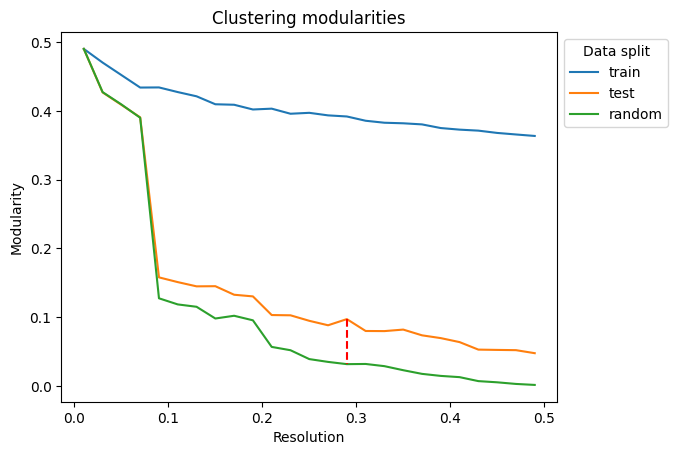

In [73]:
fig, ax = plt.subplots()
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
ax.set(title="Clustering modularities", xlabel="Resolution", ylabel="Modularity")

ax.plot(
    [res_opt, res_opt],
    [
        mod_df[(mod_df["resolution"] == res_opt) & (mod_df["type"] == "test")]["score"],
        mod_df[(mod_df["resolution"] == res_opt) & (mod_df["type"] == "random")][
            "score"
        ],
    ],
    linestyle="dashed",
    color="red",
)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.legend_.set_title("Data split")

plt.savefig(f"{figure_path}/modularities_plot_nmd_NMDCluster.svg", format="svg")
plt.show()

In [74]:
sc.pp.neighbors(
    data,
    n_neighbors=n_neighbors_opt,
    n_pcs=int(k_opt),
    use_rep="X_nmd",
    key_added="NMD",
)

In [75]:
sc.tl.leiden(
    data,
    resolution=res_opt,
    key_added="leiden_opt_NMD",
    neighbors_key="NMD",
)

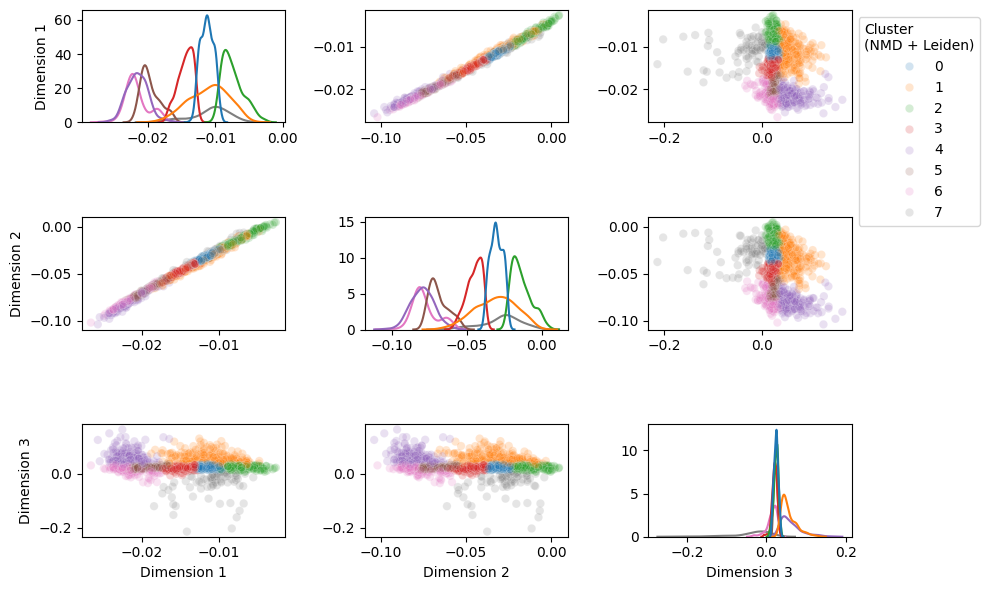

In [76]:
embeddings_2_plot = data.obsm["X_nmd"]
_, p = embeddings_2_plot.shape

fig, axs = plt.subplots(p, p, figsize=[10, 6], sharex=False)

hist_y_lim = [0, 250]
hist_bins = 20

scatter_lim = [embeddings_2_plot.min() - 0.01, embeddings_2_plot.max() + 0.01]
scatter_alpha = 0.2

scatter_hue = data.obs["leiden_opt_NMD"]


for i, row in enumerate(axs):
    for j, axis in enumerate(row):
        if i == j:
            sns.kdeplot(
                x=embeddings_2_plot[:, i : (i + 1)].flatten(),
                ax=axis,
                legend=False,
                hue=scatter_hue,
            )
        else:
            use_legend = (i == 0 and j == (p - 1)) and (scatter_hue is not None)
            sns.scatterplot(
                y=embeddings_2_plot[:, i : (i + 1)].flatten(),
                x=embeddings_2_plot[:, j : (j + 1)].flatten(),
                alpha=scatter_alpha,
                hue=scatter_hue,
                ax=axis,
                legend=use_legend,
            )
            if use_legend:
                sns.move_legend(axis, "upper left", bbox_to_anchor=(1, 1))
                axis.legend_.set_title("Cluster\n(NMD + Leiden)")
        if j == 0:
            axis.set_ylabel(f"Dimension {i + 1}")
        else:
            axis.set_ylabel(None)
        if i == len(row) - 1:
            axis.set_xlabel(f"Dimension {j + 1}")
        else:
            axis.set_xlabel(None)

plt.tight_layout()


# plt.savefig(fig_path_rank3_norm_nmd + "embedding_plot_nmd_norm_r3_hueNMDCluster_diagKDE.svg", format="svg")
plt.show()

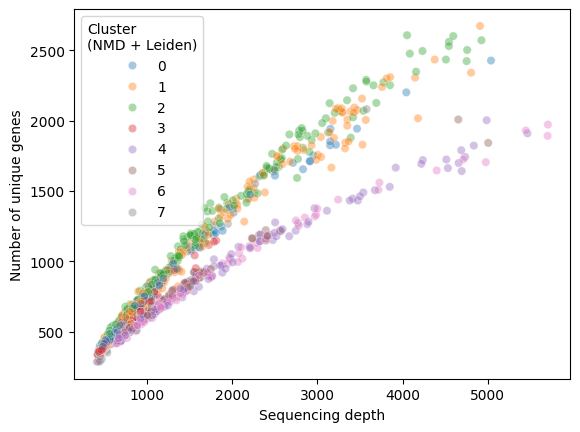

In [77]:
scatter_seqdepth_uniquegenes_hue_nmd_normr3_leidenopt = sns.scatterplot(
    x=data.obs["total_counts"],
    y=data.obs["n_genes"],
    hue=data.obs["leiden_opt_NMD"],
    alpha=0.4,
)
plt.ylabel("Number of unique genes")
plt.xlabel("Sequencing depth")
scatter_seqdepth_uniquegenes_hue_nmd_normr3_leidenopt.axes.legend_.set_title(
    "Cluster\n(NMD + Leiden)"
)

# plt.savefig(fig_path_rank3_norm_nmd + "./scatter_seqdepth_uniquegenes_hue_nmd_normr3_leidenopt.svg", format="svg")

plt.show()

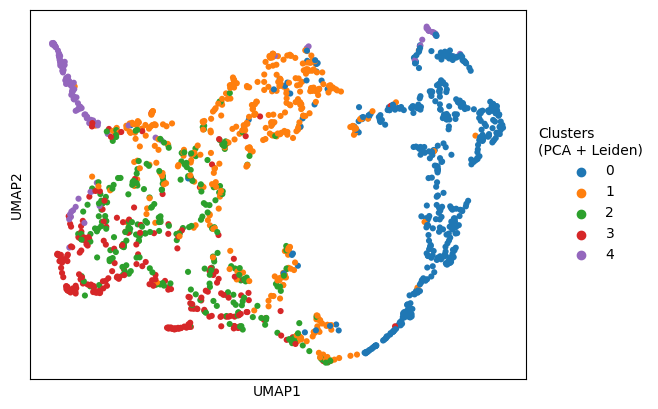

In [78]:
umap_pca_leiden_opt = sc.pl.umap(
    data, color="leiden_opt_PCA", return_fig=True, palette=sns.color_palette("tab10")
)
ax = umap_pca_leiden_opt.axes[0]
ax.legend_.set_title("Clusters\n(PCA + Leiden)")
ax.set_title(None)
# plt.savefig("./pca_umap_pca_cluster.svg")
plt.show()

... storing 'gene_dist' as categorical


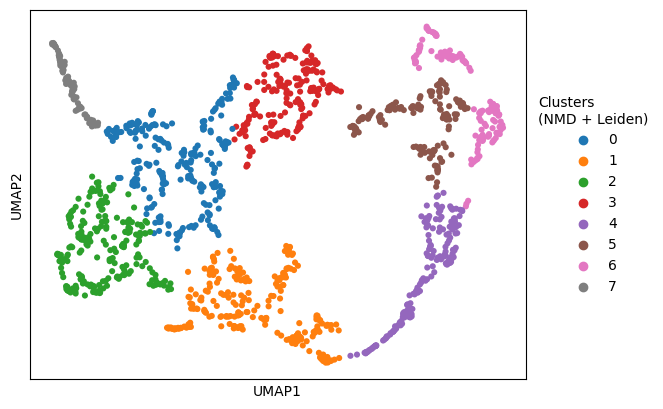

In [84]:
umap_pca_leiden_opt = sc.pl.umap(
    data, color="leiden_opt_NMD", return_fig=True, palette=sns.color_palette("tab10")
)
ax = umap_pca_leiden_opt.axes[0]
ax.legend_.set_title("Clusters\n(NMD + Leiden)")
ax.set_title(None)
# plt.savefig("./pca_umap_pca_cluster.svg")
plt.show()

## Differential expression

In [79]:
sc.tl.rank_genes_groups(data, "leiden_opt_NMD", method="wilcoxon")

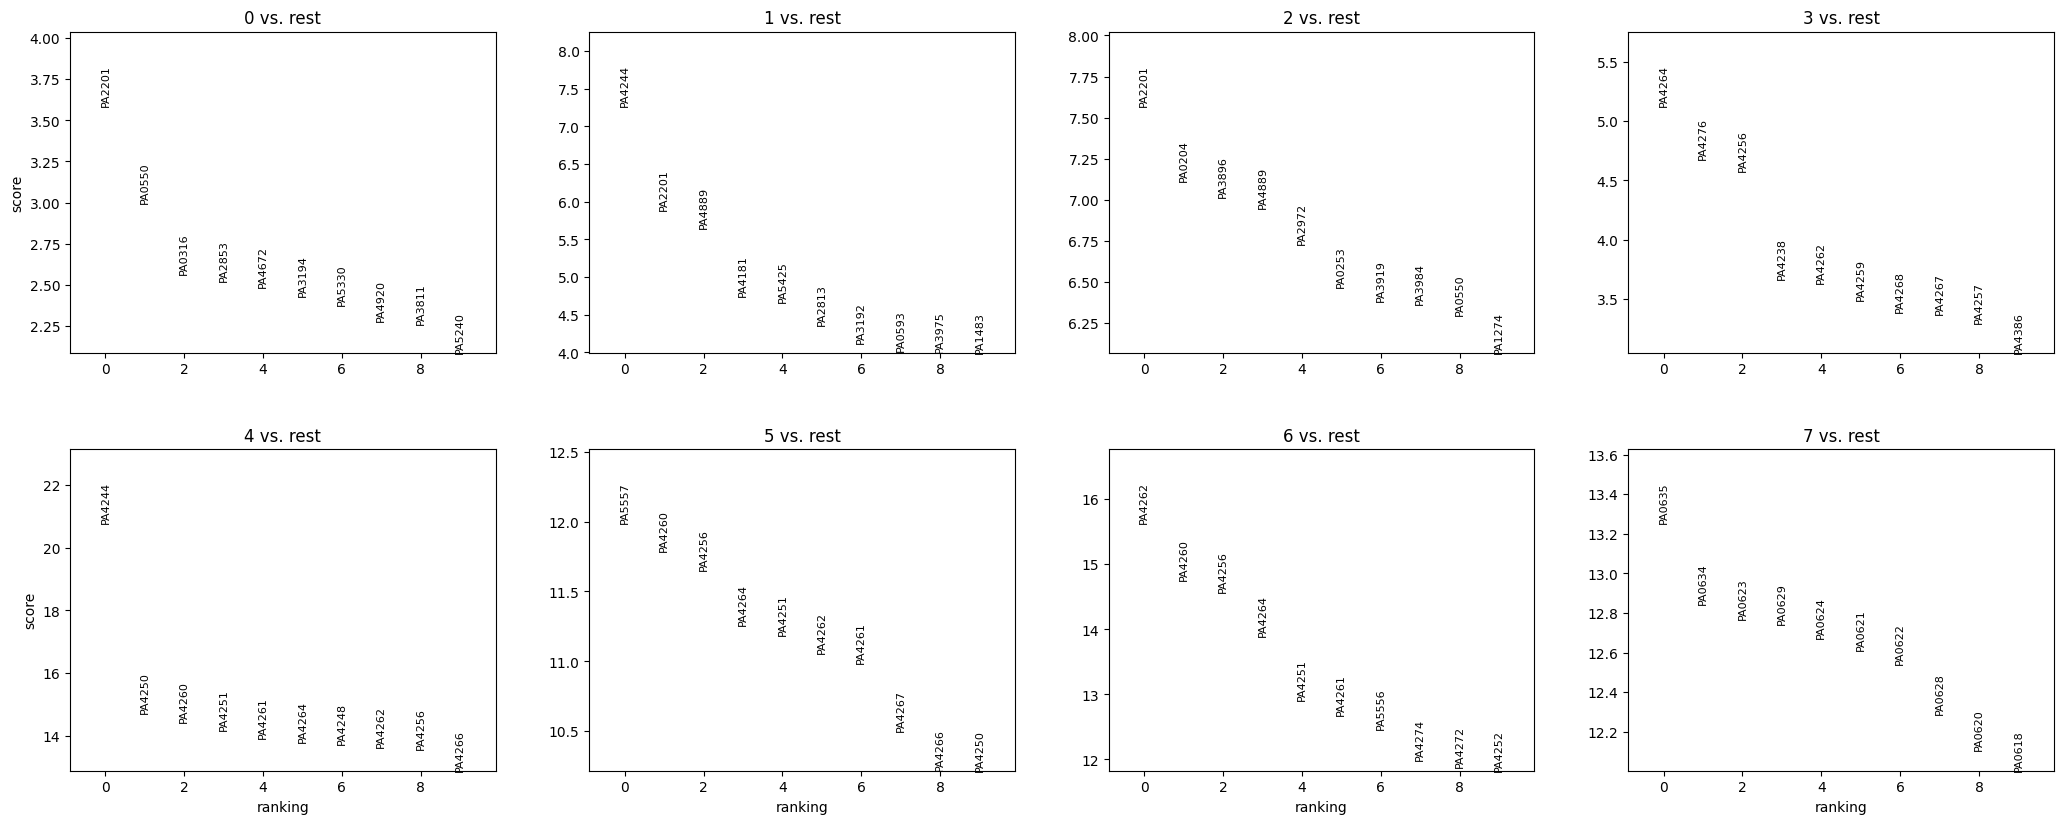

In [109]:
sc.pl.rank_genes_groups(data, n_genes=10, sharey=False)

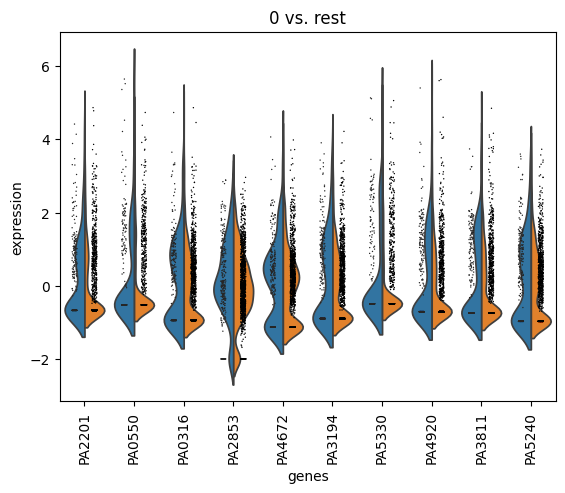

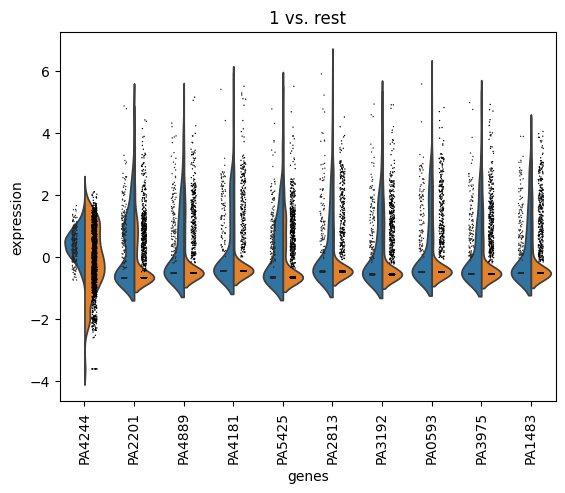

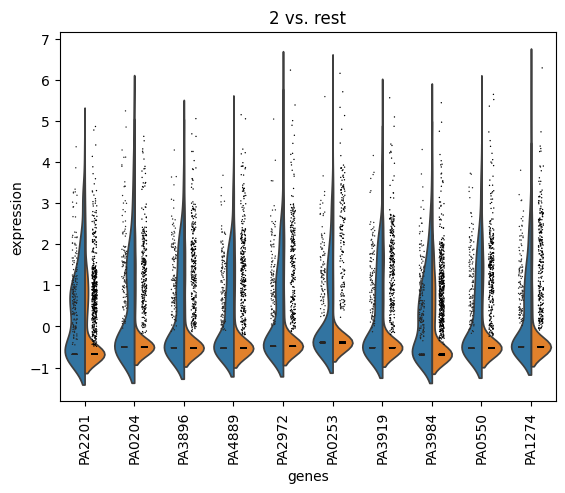

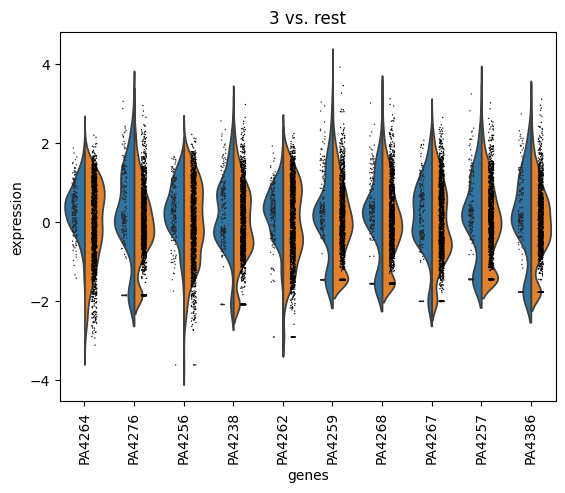

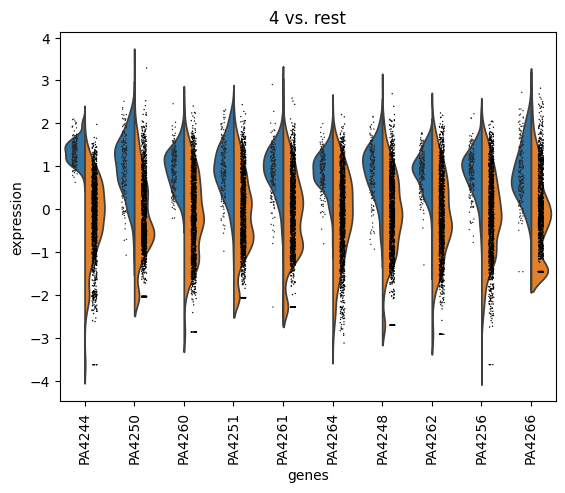

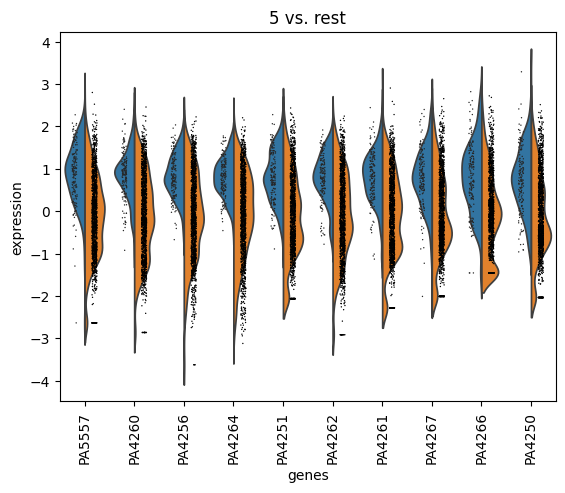

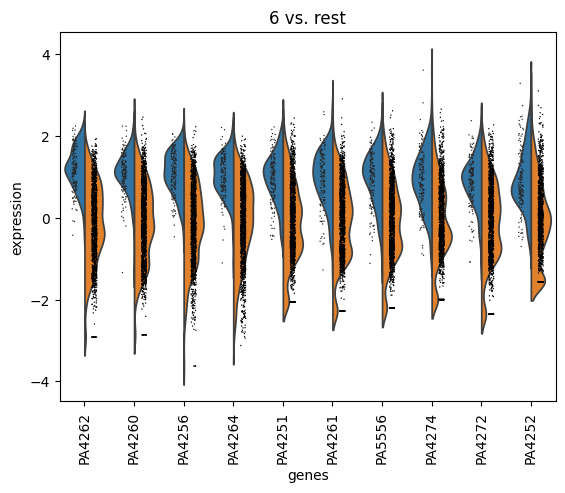

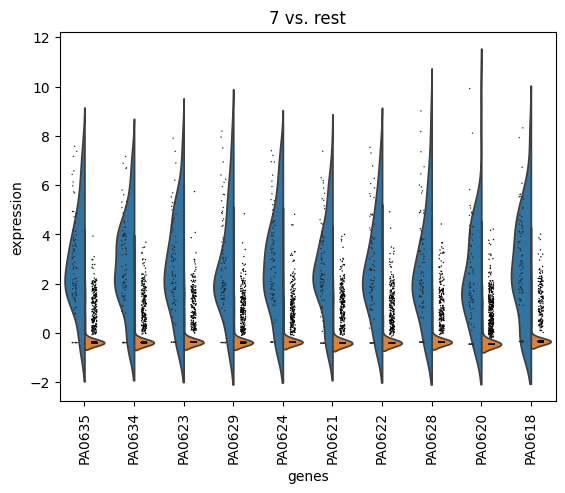

In [110]:
nclust = len(np.unique(data.obs["leiden_opt_NMD"]))

for i in range(nclust):
    sc.pl.rank_genes_groups_violin(data, groups=str(i), n_genes=10)

In [111]:
data.write(data_path + "/nmd_normalized_counts_r3.h5ad")